# Practical session demo

We are going to take a look at the different functionalities:
* Create a design of experiments
* Sample from this space
* Evaluate the samples using a well-known benchmark function
* Iteratively find the minimum of the loss-landscape using an optimizer
* Look at how we can optimize a loss-function incorporating multiple realizations

First things first, import the `f3dasm` package, and some other packages:

In [1]:
import f3dasm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pytest
from cycler import cycler

# After you import f3dasm, you will see a tensorflow information/warning message. If you know how to get rid of this, please let me know!

2022-10-28 10:45:18.849231: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


make sure that we specify a `seed` for all the random number generators:

In [2]:
seed = 42

### Design: Creating the design space

**Parameters**

There are three different parameters you can construct:
* We can create continuous parameters with a `lower_bound` and `upper_bound` (optional) with the `f3dasm.ContinuousParameter` class
* We can create discrete parameters with a `lower_bound` and `upper_bound` with the `f3dasm.DiscreteParameter` class
* We can create categorical parameters with a list of strings (categories) with the `f3dasm.CategoricalParameter` class

all parameters also require a `name`.

**Design space**

Parameters define the `f3dasm.DesignSpace` and can be constructed by calling the `f3dasm.DesignSpace` class and providing:
* a list of input parameters (`input_space`) 
* a list of output parameters (`output_space`)


***
**Exercise #1**

Create a `DesignSpace` with the following features:
* 2 continuous input parameters named `x0` and `x1`, both with the same range of `-1.0` to `1.0`
* 1 continuous output parameter named `y`
* Call this designspace `design`
***

In [3]:
## YOUR CODE HERE ##

In [4]:
## SOLUTION ##

# Input parameters
x1 = f3dasm.ContinuousParameter(name="x0", lower_bound=-1., upper_bound=1.)
x2 = f3dasm.ContinuousParameter(name="x1", lower_bound=-1., upper_bound=1.)

# Output parameters
y = f3dasm.ContinuousParameter(name="y")

# Create lists of parameters
input_space = [x1, x2]
output_space = [y]

# Construct the design space
design = f3dasm.DesignSpace(input_space=input_space, output_space=output_space)

In [5]:
## CHECK ##

assert design == f3dasm.make_nd_continuous_design(bounds=np.tile([-1., 1.], (2,1)), dimensionality=2)

What's next? We can sample from this design space with the **sampling** block!

### Sampling: Latin Hypercube Sampler

Samplers can be found within the submodule `f3dasm.sampling`. Currently 3 samplers are readily available:
* Random Uniform Sampling (`f3dasm.sampling.RandomUniformSampling`)
* Latin Hypercube Sampling(`f3dasm.sampling.LatinHypercubeSampling`)
* Sobol Sequence Sampling (`f3dasm.sampling.SobolSequenceSampling`)

**Creating a sampler object**
A new sampler can be created by initializing the sampler with:
* A design space
* A random seed (optional)

After that, you can sample by invoking the `get_samples(numsamples)`, where `numsamples` is the number of samples you want to get

***
<b>Exercise #2</b>

Now you are going to create a sampler and sample some points from the designspace:
* Create a <u>Random Uniform sampling</u> with the designspace and seed described above
* Sample 30 points from the designspace
* Store the resulting `Data`-object in the variable `samples_random`
* Do the same with <u>Latin Hypercube sampling</u> and store the samples as `samples_lhs`
***

In [6]:
## YOUR CODE HERE ##



# If you are stuck you may uncomment the following lines to import the data object directly:
# samples_lhs = f3dasm.read_pickle('exercise_samples_lhs')
# samples_random = f3dasm.read_pickle('exercise_samples_random')

In [7]:
## SOLUTION ##

# Construct sampler
random_sampler = f3dasm.sampling.RandomUniformSampling(design=design,seed=seed)
lhs_sampler = f3dasm.sampling.LatinHypercubeSampling(design=design, seed=seed)

N = 30 # Number of samples

# Get samples
samples_random = random_sampler.get_samples(numsamples=N)
samples_lhs = lhs_sampler.get_samples(numsamples=N)

# f3dasm.write_pickle('exercise_samples_lhs', samples_lhs)
# f3dasm.write_pickle('exercise_samples_random', samples_random)

In [8]:
## CHECK ##

assert samples_lhs.data.equals(f3dasm.read_pickle('exercise_samples_lhs').data)
assert samples_random.data.equals(f3dasm.read_pickle('exercise_samples_random').data)

We can plot the datapoints with the `data.plot()` function:

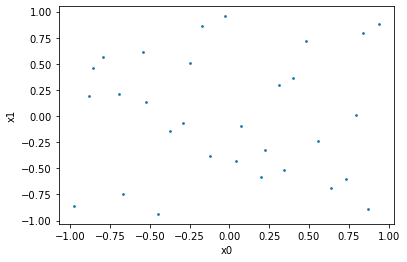

In [9]:
fig, ax = samples_lhs.plot(input_par1='x0', input_par2='x1')

In [10]:
samples_random.data

input           output
          x0        x1      y
0  -0.250920  0.901429    NaN
1   0.463988  0.197317    NaN
2  -0.687963 -0.688011    NaN
3  -0.883833  0.732352    NaN
4   0.202230  0.416145    NaN
5  -0.958831  0.939820    NaN
6   0.664885 -0.575322    NaN
7  -0.636350 -0.633191    NaN
8  -0.391516  0.049513    NaN
9  -0.136110 -0.417542    NaN
10  0.223706 -0.721012    NaN
11 -0.415711 -0.267276    NaN
12 -0.087860  0.570352    NaN
13 -0.600652  0.028469    NaN
14  0.184829 -0.907099    NaN
15  0.215090 -0.658952    NaN
16 -0.869897  0.897771    NaN
17  0.931264  0.616795    NaN
18 -0.390772 -0.804656    NaN
19  0.368466 -0.119695    NaN
20 -0.755924 -0.009646    NaN
21 -0.931223  0.818641    NaN
22 -0.482440  0.325045    NaN
23 -0.376578  0.040136    NaN
24  0.093421 -0.630291    NaN
25  0.939169  0.550266    NaN
26  0.878998  0.789655    NaN
27  0.195800  0.843748    NaN
28 -0.823015 -0.608034    NaN
29 -0.909545 -0.349339    NaN

As you could see earlier, the output values are all `NaN`. Let's evaluate the samples with a benchmark function from the **simulation** block!

### Simulation: Evaluating a benchmark function

Several benchmark functions have been implemented in the submodule `f3dasm.functions` to work with **continuous and single-objective** optimization problems.

These functions require an input-vector $\mathbf{x}$ and output a scalar $f(\mathbf{x})$

The `Levy()` function is a well-known, multimodal function:

$f(\textbf{x}) = \sin^2 (\pi w_1) + \sum_{i = 1}^{D - 1} (w_i - 1)^2 \left( 1 + 10 \sin^2 (\pi w_i + 1) \right) + (w_d - 1)^2 (1 + \sin^2 (2 \pi w_d)) \\ w_i = 1 + \frac{x_i - 1}{4}`
$


First we create such a function `f` by creating an object from the `f3dasm.functions.Levy` class

> *The original input domain is (-10, 10), but we scale these boundaries to the boundaries our input space*

In [11]:
dim = 2
domain = np.tile([-1., 1.], (dim,1))

In [12]:
f = f3dasm.functions.Levy(dimensionality=dim, seed=seed, scale_bounds=domain)

The global minima are known for these functions and can be accesed by the `get_global_minimum()` function:

In [13]:
x_min, y_min = f.get_global_minimum(dim)
print(f"The global minimum is {y_min} at position {x_min}")

The global minimum is [[1.49975978e-32]] at position [[-0.25091976  0.90142861]]


We can plot a three-dimensional loss-landscape of the two input parameters $x_0$ and $x_1$ with the `plot()` function:
* `px` denotes the resolution on each axis
* `domain` denotes the domain of the two axis to be plotted

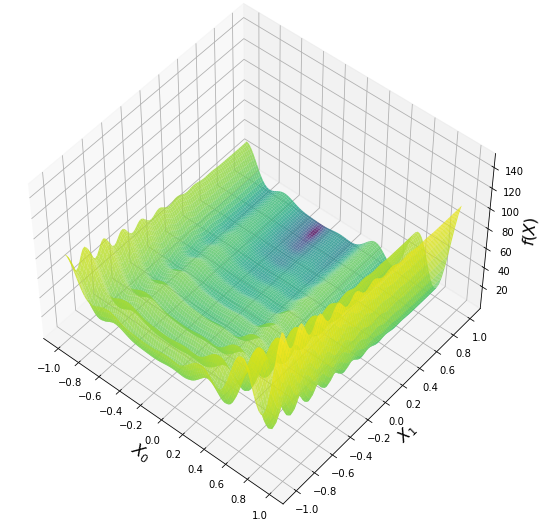

In [14]:
fig, ax = f.plot(px=100, domain=domain)

Evaluating the function is easy, just pass either:
* the `Data()` object to it: `get_input_data()`
* or a 2D numpy array: `get_input_data().to_numpy()`

.. and all the samples will be evaluated.
The output will be a `np.ndarray`

In [15]:
x = samples_lhs.get_input_data()

By calling the `add_output` option, we can add individual columns or overwrite data to our DataFrame:

In [16]:
samples_lhs.add_output(output=f(x))

In [17]:
samples_lhs.show()

       input               output
          x0        x1          y
0   0.220308 -0.324034  26.355218
1  -0.796128  0.568005   4.263000
2  -0.665294 -0.742255  31.199620
3  -0.884534  0.187226  23.444474
4  -0.693259  0.206511  12.032306
5  -0.371204 -0.147655  10.968711
6   0.731306 -0.602006  60.866823
7   0.839860  0.792988   9.647400
8   0.936348  0.879732  62.882185
9  -0.120022 -0.380585  21.448574
10  0.071003 -0.099051   8.156905
11 -0.856265  0.460621  12.513259
12 -0.292543 -0.063570   7.565207
13  0.402293  0.366345   7.208715
14 -0.521212  0.129926   9.308220
15 -0.247190  0.510835   0.975770
16  0.312282  0.296010  16.590724
17  0.483919  0.718342  11.264005
18 -0.544504  0.612324   7.136091
19 -0.975031 -0.856267  62.994914
20  0.636447 -0.686128  70.230530
21  0.795967  0.011368  20.275172
22 -0.446384 -0.936619  29.659466
23  0.872566 -0.893423  40.384370
24  0.554114 -0.242243  47.230535
25  0.341469 -0.521106  24.981558
26 -0.027172  0.955022   1.746209
27  0.197709 -

Let's store these samples under a new name `data`:

We can create a contour plot with the samples coordinates with the `plot_data()` function: 

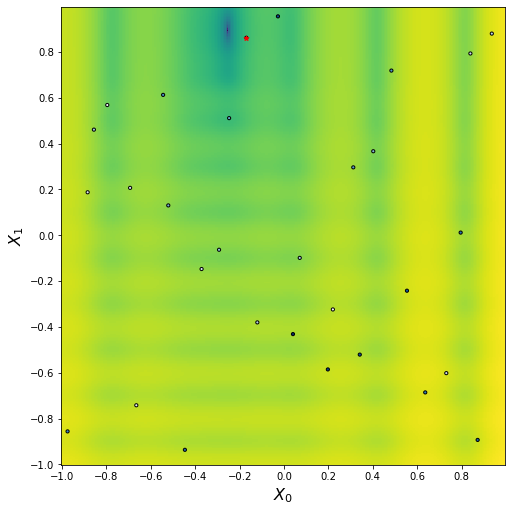

In [18]:
fig, ax = f.plot_data(samples_lhs,px=300,domain=domain)

> The red star will indicate the best sample



***
**Exercise #3**

* By consulting the documentation, find the location of the best sample obtainted by Latin Hypercube sampling (the red star)
* Store this value as `x_best`
***

In [19]:
## YOUR CODE HERE ##


In [20]:
## SOLUTION ##

x_best = samples_lhs.get_n_best_input_parameters_numpy(nosamples=1)

print(f"The location of the red start is {x_best}")

# f3dasm.write_pickle('exercise_best_sample', x_best)

The location of the red start is [[-0.16959533  0.86145828]]


In [21]:
## CHECK ##

assert (x_best == f3dasm.read_pickle('exercise_best_sample')).all()

Now we will take a look how we can find the minimum of this loss-function with an optimizer!

### Optimization: CMAES optimizer

Optimizers can be found in the submodule `f3dasm.optimization` and are ported from several libraries such as `GPyOpt`, `scipy-optimize`, `tensorflow` and `pygmo`

We will use the CMAES optimizer to find the minimum. We can find an implementation in the `f3dasm.optimization` module:

In [22]:
optimizer = f3dasm.optimization.CMAES(data=copy.copy(samples_lhs))

By calling the `iterate()` method and specifying the function and the number of iterations, we will start the optimization process:

In [23]:
optimizer.iterate(iterations=100, function=f)

After that, we can extract the data:

In [24]:
cmaes_data = optimizer.extract_data()

... and create a contour plot again:

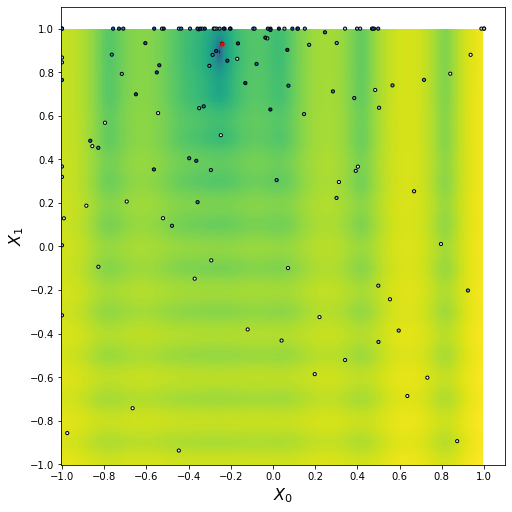

In [25]:
fig, ax = f.plot_data(data=cmaes_data,px=300, domain=domain)

**Hyperparameters**

You can overwrite the default hyperparameters of each optimizer by supplying a dictionary to the optimizer initializer.
The parameters of the optimizer can be viewed by calling the `parameter` attribute:

In [26]:
optimizer.parameter

CMAES_Parameters(population=30, force_bounds=True, gen=1, memory=True)

***
**Exercise #4**
* Retrieve the default `learning_rate` parameter of the `Adam` optimizer
* Optimize the same `Levy()`-function 50 iterations but now with the `Adam` optimizer with a `learning_rate` parameter of `2.0e-3`
* Extract the data and call it `adam_data`
* Plot the loss-landscape and data with the `plot_data` function
***


In [27]:
## YOUR CODE HERE ##


The default learning rate of the Adam optimizer is 1.0E-03


2022-10-28 10:45:35.252452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


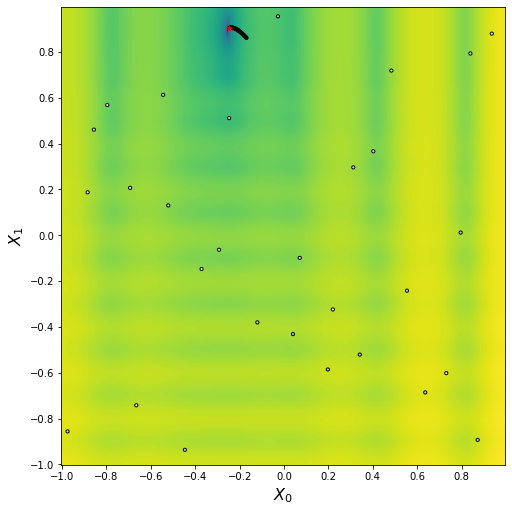

In [28]:
## SOLUTIONS ##

# Retrieve the default learning_rate parameter of the Adam optimizer
print(f"The default learning rate of the Adam optimizer is {f3dasm.optimization.Adam_Parameters().learning_rate:.1E}")

# Optimize the same Levy()-function for 50 iterations but now with the Adam optimizer with a learning_rate parameter of 2.0e-3
optimizer_adam = f3dasm.optimization.Adam(data=copy.copy(samples_lhs), hyperparameters={'learning_rate': 2e-3}, seed=seed)
optimizer_adam.iterate(iterations=50, function=f)

# Extract the data and call it adam_data
adam_data = optimizer_adam.extract_data()

# Plot the loss-landscape and data with the `plot_data` function
fig2, ax2 = f.plot_data(data=adam_data, px=300, domain=domain)

# f3dasm.write_pickle('exercise_adam_optimization',adam_data)

In [29]:
## CHECK ##

assert f3dasm.read_pickle('exercise_adam_optimization').data.to_numpy() == pytest.approx(adam_data.data.to_numpy())

### Experiment: Multiple realizations of SGA on 20D Ackley function

Now we take a look at an example of an experiment where use the following blocks to optimize a 20D Ackley function with the CMAES optimizer over 10 different realizations:

In [30]:
# Define the blocks:
dimensionality = 20
iterations = 600
realizations = 10

hyperparameters= {} # If none are selected, the default ones are used

domain = np.tile([-1., 1.], (dimensionality,1))
design = f3dasm.make_nd_continuous_design(bounds=domain, dimensionality=dimensionality)
data = f3dasm.Data(design)

In [31]:
# We can put them in a dictionary if we want

implementation = {
'realizations': realizations,
'optimizer': f3dasm.optimization.SGD(data=data, hyperparameters=hyperparameters), 
'function': f3dasm.functions.Ackley(dimensionality=dimensionality, scale_bounds=domain),
'sampler': f3dasm.sampling.LatinHypercubeSampling(design, seed=seed),
'iterations': iterations,
'seed': seed
}

The `run_multiple_realizations()` function will be the pipeline of this experiment:

In [32]:
results = f3dasm.run_multiple_realizations(**implementation)

2022-10-28 10:46:09,406 - Optimized Ackley function (seed=None, dim=20) with SGD optimizer for 10 realizations!


In [33]:
cc = (cycler(color=list('bgrcmyk')) *
      cycler(linestyle=['-', '--', 'dotted']))

In [34]:
def calc_mean_std(results):
    mean_y = pd.concat([d.get_output_data().cummin() for d in results], axis=1).mean(axis=1)
    std_y = pd.concat([d.get_output_data().cummin() for d in results], axis=1).std(axis=1)
    return mean_y, std_y

In [35]:
def create_axis(results: f3dasm.OptimizationResult, ax):
    mean_y, _ = calc_mean_std(results.data)

    ax.plot(mean_y, label=f"optimizer={results.optimizer}")
    return ax

In [36]:
def plot_results(results: f3dasm.OptimizationResult):
    fig, ax = plt.figure(figsize=(15,8)), plt.axes()

    ax.set_xlabel('iterations')
    ax.set_ylabel('f(x)')
    ax.set_yscale('log')
    ax.set_prop_cycle(cc)

    for _, res in enumerate([results]):
        ax = create_axis(res, ax)

    ax.legend(loc='upper right', ncol=3, fancybox=True, shadow=True)
    return fig, ax

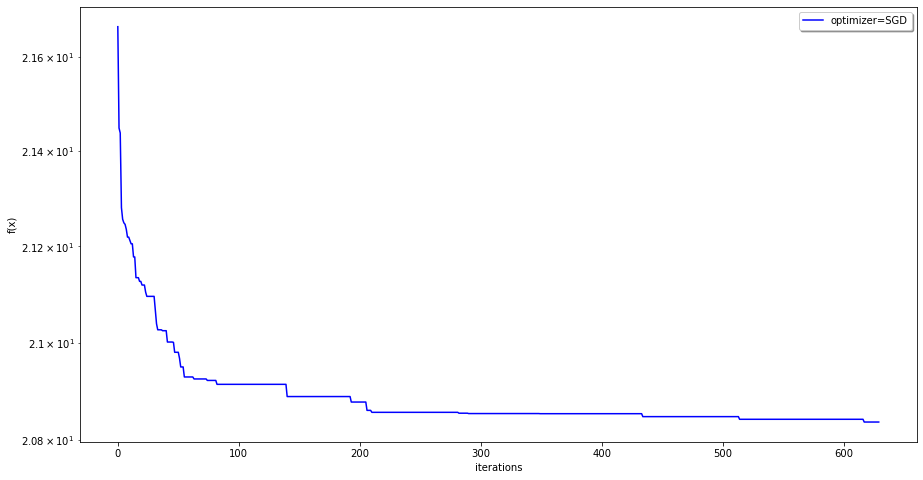

In [37]:
fig, ax = plot_results(results)

We can change a hyper-parameter such as the `learning_rate` and rerun the experiment with ease:

2022-10-28 10:46:42,185 - Optimized Ackley function (seed=None, dim=20) with SGD optimizer for 10 realizations!


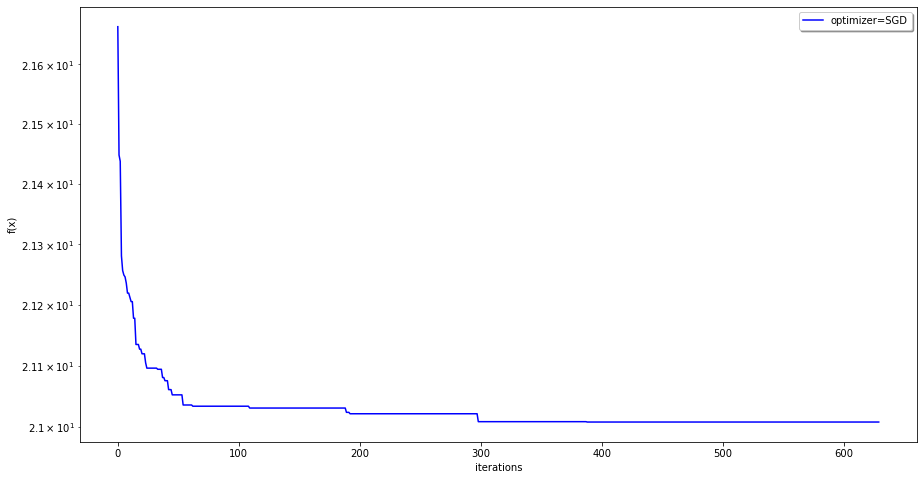

In [38]:
implementation.update({'optimizer': f3dasm.optimization.SGD(data=data, hyperparameters={'learning_rate': 3e-2})})
results_2 = f3dasm.run_multiple_realizations(**implementation)

fig2, ax2 = plot_results(results_2)

***

**Exercise #5**

Replicate the following experiment:
* Create a 6-dimensional, continuous design space with bounds for every dimension `-1.0` and `1.0`.
* Create a 6-dimensional, noiseless `Schwefel` function
* Create 40 initial samples by sampling from `SobolSequenceSampling`
* Optimize the function for 500 iterations and 5 realizations with the `PSO` optimizer. Use the default hyperparameters.
* Store the resulted `f3dasm.OptimizerResult`-object in the variable `pso_data`

*Hint #1: you can use the `f3dasm.make_nd_continuous_design()` function to quickly make a suitable design space.*

*Hint #2: a suitable domain has already been coded for you*
****

In [39]:
## YOUR CODE HERE ##

# Use this domain
dimensionality = 6
domain = np.tile([-1., 1.], (dimensionality,1))

In [40]:
## SOLUTIONS ##
dimensionality = 6
iterations = 500
realizations = 5

hyperparameters= {} # If none are selected, the default ones are used

domain = np.tile([-1., 1.], (dimensionality,1))
design = f3dasm.make_nd_continuous_design(bounds=domain, dimensionality=dimensionality)
data = f3dasm.Data(design)


implementation2 = {
'realizations': realizations,
'optimizer': f3dasm.optimization.PSO(data=data, seed=seed), 
'function': f3dasm.functions.Schwefel(dimensionality=dimensionality, scale_bounds=domain, seed=seed),
'sampler': f3dasm.sampling.SobolSequenceSampling(design, seed=seed),
'iterations': iterations,
'seed': seed
}

results_3 = f3dasm.run_multiple_realizations(**implementation2)

# f3dasm.write_pickle('exercise_pso_optimization', results_3)

2022-10-28 10:46:43,150 - Optimized Schwefel function (seed=42, dim=6) with PSO optimizer for 5 realizations!


In [41]:
## CHECK ##

pso_data: f3dasm.OptimizationResult = f3dasm.read_pickle('exercise_pso_optimization')

for index, result in enumerate(results_3.data):
    assert result.data.to_numpy() == pytest.approx(pso_data.data[index].data.to_numpy())

The average performance of the optimize can be plotted:

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:xlabel='iterations', ylabel='f(x)'>)

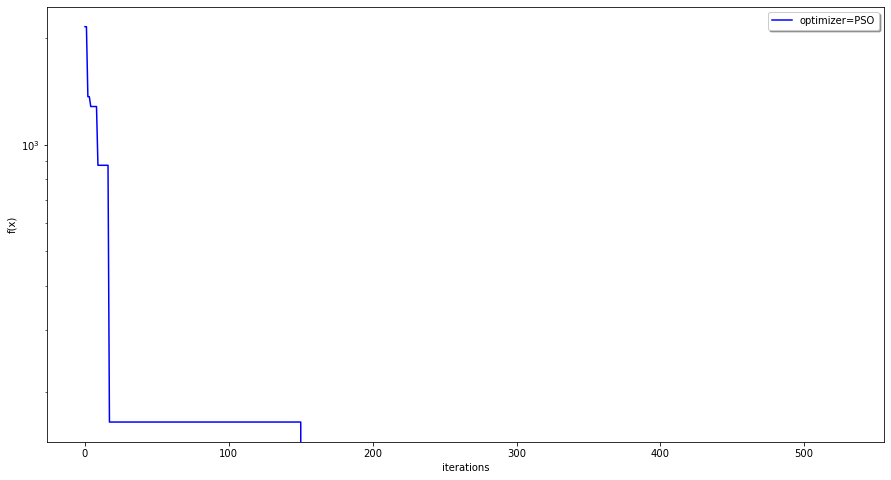

In [42]:
plot_results(results_3)